The streams were created by generating mock streams around progenitor (globular cluster) orbits sampled from a spherical, isotropic distribution function (see PDF paper draft for more details). The cluster masses (which sets the velocity dispersion, scale of the Lagrange points) are sampled from a power-law distribution with slope -2 between $10^4$ and $10^7~{\rm M}_\odot$. The background gravitational potential is smooth, but grows with time (cosmologically-motivated) -- see plots in the attached PDF. The stream particles have different masses.

The streams were saved in an HDF5 file, so I'll show you how to read them.

In [1]:
# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import h5py
import matplotlib as mpl
# Custom
import gala.coordinates as gc
import gala.dynamics as gd
import scipy.optimize as so
import imf

The top-level of the file contains 2 groups:

In [1]:
from isochrones import get_ichrone

In [2]:
import isochrones

In [3]:
isochrones.__file__

'/anaconda3/lib/python3.6/site-packages/isochrones-1.2.2.dev0-py3.6.egg/isochrones/__init__.py'

In [10]:
mist = get_ichrone('mist', tracks=False)

In [11]:
mist.initialize()

/anaconda3/lib/python3.6/site-packages/isochrones-1.2.2.dev0-py3.6.egg/isochrones/mist/models.py:43: RuntimeWarning: divide by zero encountered in log10
  df['feh'] = df['log_surf_z'] - np.log10(df['surface_h1']) - np.log10(0.0181)  # Aaron Dotter says
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


AssertionError: 

In [7]:
mist.interp_mag([1, 300, -1.5, 3e3, 0.15], ['G', 'BP', 'RP'])

(7133.255806648489,
 4.547515659273664,
 -1.7429711869623516,
 array([16.67107781, 16.85119766, 16.34271015]))

In [9]:
mist.interp_value([1, 500, -1.5, 3e3, 0.15], ['age'])

array([9.7504261])

In [2]:
f = h5py.File('sph_iso.hdf5')
print(list(f.keys()))

['progenitors', 'streams']


The `'progenitors'` group contains information about the globular clusters themselves, like the initial cluster masses, and the orbital initial conditions:

In [3]:
print(list(f['progenitors/initial'].keys()))

['mass', 'pos', 'vel']


### Check out some initial stuff about all the disrupted clusters

In [4]:
initial_radius = np.sum(f['progenitors/initial']['pos'].value**2., axis=0)
initial_velocity = np.sum(f['progenitors/initial']['vel'].value**2., axis=0)

Text(0.5,1,'initial radius')

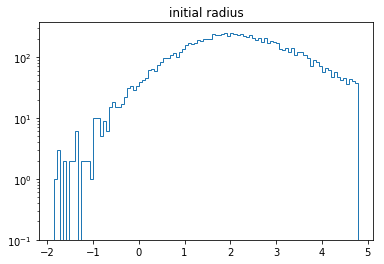

In [5]:
plt.hist(np.log10(initial_radius), bins=100, log=True, histtype='step')
plt.title('initial radius')

Text(0.5,1,'initial velocity')

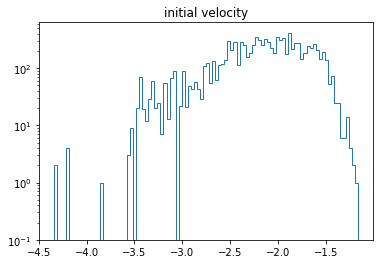

In [6]:
plt.hist(np.log10(initial_velocity), bins=100, log=True, histtype='step')
plt.title('initial velocity')

Text(0.5,1,'progenitor masses')

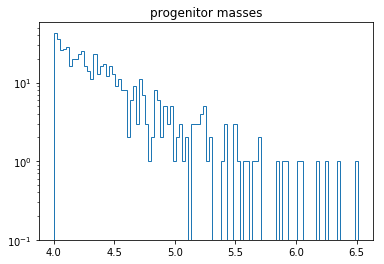

In [7]:
plt.hist(np.log10(f['progenitors/initial/mass'].value[initial_radius > 1e4]), bins=100, log=True, histtype='step')
plt.title('progenitor masses')

Text(0,0.5,'log Radius')

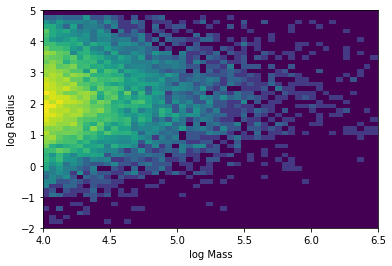

In [8]:
nbins = 50
xbins = np.linspace(4, 6.5, nbins)
ybins = np.linspace(-2, 5, nbins)
H, xe, ye = np.histogram2d(np.log10(f['progenitors/initial/mass'].value), np.log10(initial_radius), bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T + 1,
      norm=mpl.colors.LogNorm())#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
plt.xlabel('log Mass')
plt.ylabel('log Radius')

In [9]:
tdisrupt = []
for i in range(10000):
    try:
        tdisr = f['streams/{0}/t_disrupt'.format(i)].value
        tdisrupt.append(tdisr)
    except KeyError:
        tdisrupt.append(np.NaN)


In [10]:
np.where(f['progenitors/initial/mass'].value == np.min(f['progenitors/initial/mass'].value[~np.isnan(tdisrupt) & 
                                                                                           (initial_velocity > 1e-2) & 
                                                                                          (initial_radius > 1e4)]))

(array([6953]),)

### Choose stream that's still fairly stream like

-10797.215936008448


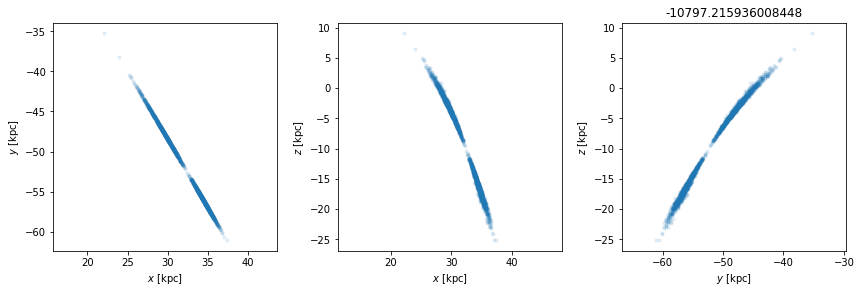

In [178]:
ind = 'streams/2911'
f[ind]['pos'].value
w = gd.PhaseSpacePosition.from_hdf5(f[ind])
_ = w.plot(alpha=0.1, marker='.')
plt.title(f[ind + '/t_disrupt'].value)
print(f[ind + '/t_disrupt'].value)

In [69]:
print(list(f[ind + '/final'].keys()))
print(list(f[ind].keys()))

['mass', 'pos', 'vel']
['final', 'pos', 't_disrupt', 'vel', 'weights']


In [70]:
probabilities = f[ind+'/weights'].value/np.sum(f[ind+'/weights'].value)

### Find the faintest magnitude Gaia could observe for each particle

In [81]:
streamTotalMass = np.sum(f[ind + '/weights'].value)
streamDistancefromEarth = np.sqrt((f[ind+'/pos'][0] - 8.)**2 + f[ind+'/pos'][1]**2 + f[ind+'/pos'][2]**2)

In [90]:
gaiaMagLimit = 17*u.mag
limitingObsMag = gaiaMagLimit - coord.Distance(streamDistancefromEarth*u.kpc).distmod

Text(0.5,1,'distance modulus to stream')

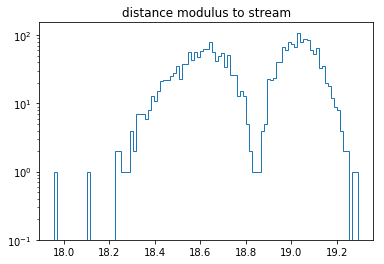

In [88]:
plt.hist(coord.Distance(streamDistancefromEarth*u.kpc).distmod.value, log=True, histtype='step', bins=100)
plt.title('distance modulus to stream')

Text(0.5,1,'limiting magnitudes')

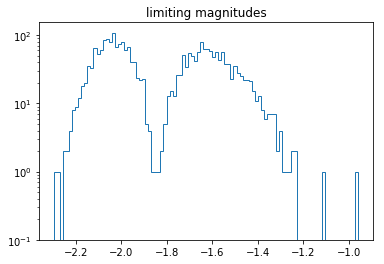

In [93]:
plt.hist(limitingObsMag.value, log=True, histtype='step', bins=100)
plt.title('limiting magnitudes')

In [67]:
n = len(probabilities)
indices = np.random.choice(n, size=50, replace=False, p=probabilities)

### Sample the IMF to get enough stars to populate the stream down to the limiting magnitude 

In [19]:
k01 = imf.Kroupa2001()

In [141]:
np.sum(k01.random(30000)), np.sum(f[ind + '/weights'].value)

(11614.766903168851, 10013.745192694765)

#we want to sample the IMF such that we get the same amount of mass as the stream contains fully 
def massDiff(n, ind='streams/2911'):
    np.random.seed(0)
    diff = np.sum(f[ind + '/weights'].value) - np.sum(k01.random(n))
    print(diff)
    return np.abs(diff)
result = so.minimize(massDiff, 0)
print(result)

In [158]:
def massDiff(nmin = 0, nmax=1e7, ind='streams/2911'):
    for i in range(25):
        n = 0.5*(nmin + nmax)
        np.random.seed(0)
        sumDiff = np.sum(f[ind + '/weights'].value) - np.sum(k01.random(n))
        if sumDiff > 0:
            nmin = n
        if sumDiff < 0:
            nmax = n
    print(n, sumDiff, )
    return n

In [159]:
massDiff()

25896.131992340088 -0.05266277831469779


25896.131992340088

In [162]:
n = massDiff()
np.random.seed(0)
masses = k01.random(n)

25896.131992340088 -0.05266277831469779


In [163]:
np.sum(masses), np.sum(f[ind + '/weights'].value)

(10013.79785547308, 10013.745192694765)

Text(0.5,0,'log star mass')

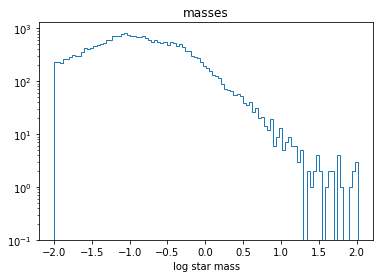

In [164]:
plt.hist(np.log10(masses), log=True, histtype='step', bins=100)
plt.title('masses')
plt.xlabel('log star mass')

In [166]:
massSort = np.sort(masses)

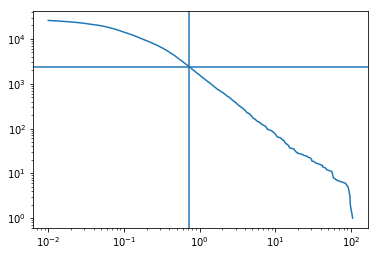

In [180]:
plt.loglog(massSort[::-1], np.cumsum(np.ones(len(massSort))))
plt.axhline(len(f[ind + '/weights'].value))
index = np.where(np.cumsum(np.ones(len(massSort))) == len(f[ind + '/weights'].value))
minmass = massSort[::-1][index]
plt.axvline(minmass)

In [185]:
massSortInvert = massSort[::-1]

In [191]:
index[0][0]

2395

In [194]:
massesChosen = massSortInvert[:index[0][0]]

In [195]:
import isochrones

problem: dlopen(libmultinest.dylib, 6): image not found


SystemExit: 1

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [27]:
val = 2911
for val in np.random.randint(0, 10000, 10):

    print(f['progenitors/initial/mass'][val])
    print(f['streams/' + str(val) + '/final/mass'].value)
    print(np.sum(f['streams/'+ str(val) + '/weights'].value))

23293.1485080738
0.0
23292.148508058912
17076.639288063066
0.0
17075.639288052163
15572.947961669273
0.0
15571.947961659342
18526.213364382333
0.0
18525.21336437052
27342.706143681746
0.0
27341.706143664298
20260.270976205586
0.0
20259.270976192653
17767.21286966508
0.0
17766.212869653755
10009.05749049798
0.0
10008.057490491618
75495.12406388092
0.0
75494.12406383509
17703.74407191872
0.0
17702.744071907426


In [28]:
f['streams/2902']['pos'].value

array([[ 0.62658253,  0.13200334, -0.21372395, ..., -0.47092716,
         0.78619744,  0.43757884],
       [ 0.17868591,  0.43530476,  0.51307183, ..., -0.01173761,
         0.17050125,  0.20686204],
       [-0.08481472,  0.41048723, -0.32720698, ..., -0.09317055,
         0.00228719,  0.02376774]])

There are 10000 clusters initially, so the `mass`, `pos`, and `vel` datasets in the HDF5 file are all length 10000 (but pos and vel are (3, 10000) for the 3D cartesian positions):

In [29]:
print(f['progenitors/initial/mass'].shape,
      f['progenitors/initial/pos'].shape,
      f['progenitors/initial/vel'].shape)

(10000,) (3, 10000) (3, 10000)


But I don't think you care about those. I think you just want the streams particles! Those are in the other top-level dataset, and each of the 10000 streams are indexed (0–9999) after this group. So, for example, to get the stream particle information for stream number 371:

In [30]:
stream_info = f['streams/3']
print(list(stream_info.keys()))

['final', 'pos', 't_disrupt', 'vel', 'weights']


In [31]:
tdisrupt = np.array(tdisrupt)

10000
[5343 8432 4701 ... 8892  749 8483]


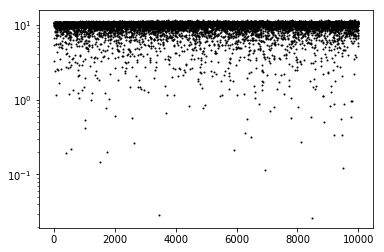

In [32]:
plt.plot(np.abs(np.array(tdisrupt)/1000.), 'ko', markersize=1)
plt.yscale('log')
print(len(tdisrupt))
print(np.argsort(np.array(tdisrupt)))

The per-stream groups also contain `pos` and `vel`, which are 3D cartesian position/velocity, but now these are the individual stream particle positions/velocities, so the number varies depending on the time at which the progenitor fully disrupts:

In [33]:
tdisrupt[~np.isnan(tdisrupt)]

array([-10290.24096318,  -3282.89403863,  -9614.0373178 , ...,
        -5138.01003316, -10329.34842953, -10773.04041136])

(array([2.000e+00, 0.000e+00, 3.000e+00, 6.000e+00, 8.000e+00, 2.100e+01,
        5.600e+01, 1.240e+02, 4.360e+02, 8.666e+03]),
 array([1.42009871, 1.68397462, 1.94785052, 2.21172642, 2.47560232,
        2.73947822, 3.00335412, 3.26723002, 3.53110592, 3.79498182,
        4.05885772]),
 <a list of 10 Patch objects>)

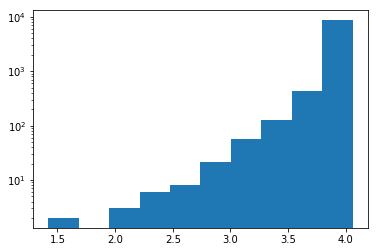

In [34]:
plt.hist(np.log10(np.abs(tdisrupt[~np.isnan(tdisrupt)])), log= True)

Text(0,0.5,'log Radius')

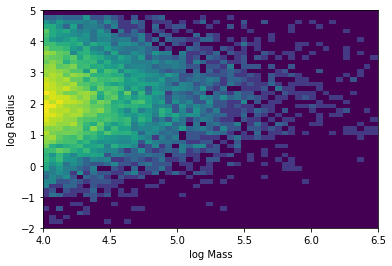

In [35]:
nbins = 50
xbins = np.linspace(4, 6.5, nbins)
ybins = np.linspace(-2, 5, nbins)
H, xe, ye = np.histogram2d(np.log10(f['progenitors/initial/mass'].value), np.log10(initial_radius), bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T + 1,
      norm=mpl.colors.LogNorm())#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
plt.xlabel('log Mass')
plt.ylabel('log Radius')

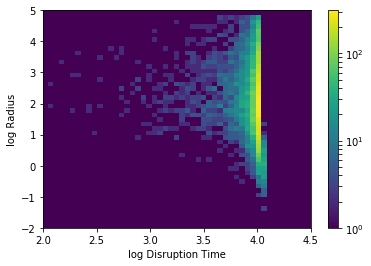

In [36]:
nbins = 50
xbins = np.linspace(2, 4.5, nbins)
ybins = np.linspace(-2, 5, nbins)
H, xe, ye = np.histogram2d(np.log10(np.abs(tdisrupt[~np.isnan(tdisrupt)])), np.log10(initial_radius[~np.isnan(tdisrupt)]), bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T + 1,
      norm=mpl.colors.LogNorm())#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
plt.xlabel('log Disruption Time')
plt.ylabel('log Radius')
plt.colorbar()

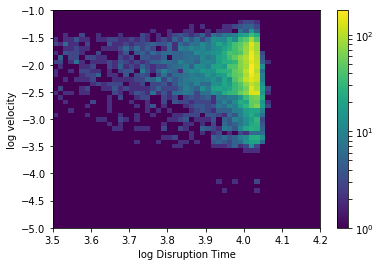

In [37]:
nbins = 50
xbins = np.linspace(3.5, 4.2, nbins)
ybins = np.linspace(-5, -1, nbins)
H, xe, ye = np.histogram2d(np.log10(np.abs(tdisrupt[~np.isnan(tdisrupt)])), np.log10(initial_velocity[~np.isnan(tdisrupt)]), bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T + 1,
      norm=mpl.colors.LogNorm())#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
plt.xlabel('log Disruption Time')
plt.ylabel('log velocity')
plt.colorbar()

In [38]:
stream_info['pos'].shape

(3, 5724)

The time of full disruption is in `'t_disrupt'`, and it's stored as a scalar dataset in units of Myr (0 is z=0):

In [39]:
stream_info['t_disrupt'].value * u.Myr

<Quantity -9614.0373178 Myr>

To make a spherically-averaged mass profile of all of the stream stars, we have to loop over stream index. Rather than loading all data into memory, here we bin each individual stream in spherical radius and then coadd the binned values:

In [40]:
bins = np.logspace(-1., np.log10(300), 33) # 0.1 to 300 kpc
all_H = np.zeros(bins.size-1)

count = 0
for key in f['streams']:
    i = int(key)
    if i % 1000 == 0 and i > 0:
        print(key)

    count += 1
    pos = f['streams'][key]['pos'][:]
    if pos.shape[1] > 0:
        r = np.sqrt(np.sum(pos**2, axis=0))
        w = f['streams'][key]['weights'][:]
        H, _ = np.histogram(r, bins=bins, weights=w)
        all_H += H

V = 4/3*np.pi*(bins[1:]**3 - bins[:-1]**3)
bin_cen = (bins[1:]+bins[:-1])/2.

1000
2000
3000
4000
5000
6000
7000
8000
9000


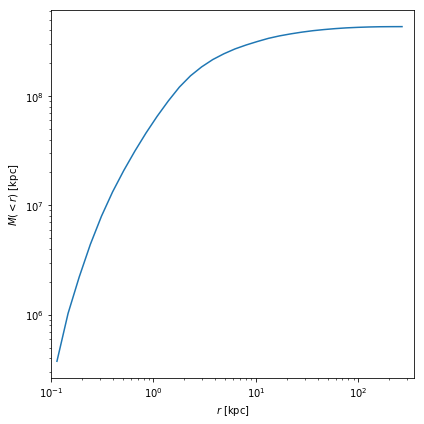

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.loglog(bin_cen, np.cumsum(all_H), ls='-', marker='', lw=1.5)

ax.set_xlim(0.1, 350)
ax.set_xlabel('$r$ [kpc]')
ax.set_ylabel(r'$M(<r)$ [kpc]')

fig.tight_layout()

With `gala`, you can load the streams in as phase-space position objects, which we can use to easily plot or convert to observable coordinates:

-10797.215936008448


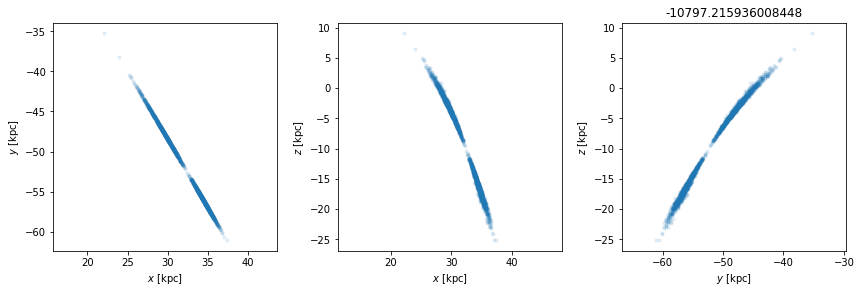

In [42]:
f['streams/2902']['pos'].value
w = gd.PhaseSpacePosition.from_hdf5(f['streams/2911'])
_ = w.plot(alpha=0.1, marker='.')
plt.title(f['streams/2911/t_disrupt'].value)
print(f['streams/2911/t_disrupt'].value)

nan


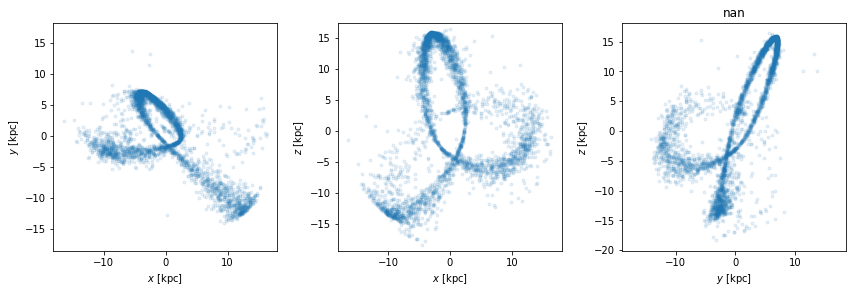

In [43]:
w = gd.PhaseSpacePosition.from_hdf5(f['streams/8483'])
_ = w.plot(alpha=0.1, marker='.')
plt.title(f['streams/8483/t_disrupt'].value)
print(f['streams/8483/t_disrupt'].value)

Text(0,0.5,'$dec$ [deg]')

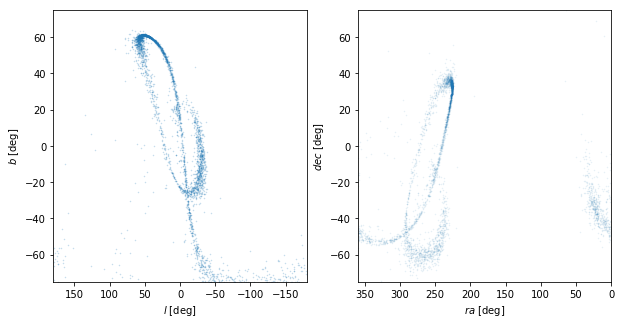

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
eq = w.to_coord_frame(coord.ICRS)
gal = w.to_coord_frame(coord.Galactic)
ax[0].plot(gal.l.wrap_at(180.*u.deg),gal.b.degree, marker='.', linestyle='none', alpha=0.25, markersize=1)
ax[1].plot(eq.ra.degree, eq.dec.degree, marker='.', linestyle='none', alpha=0.1, markersize=1)

ax[0].set_xlim(180, -180)
ax[0].set_ylim(-75, 75)

ax[1].set_xlim(360, 0)
ax[1].set_ylim(-75, 75)
ax[0].set_xlabel('$l$ [deg]')
ax[0].set_ylabel('$b$ [deg]')
ax[1].set_xlabel('$ra$ [deg]')
ax[1].set_ylabel('$dec$ [deg]')


(-10, 20)

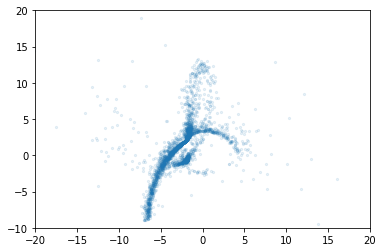

In [45]:
plt.scatter(gal.pm_l_cosb, gal.pm_b, s=5, alpha=0.1)
plt.xlim(-20, 20)
plt.ylim(-10, 20)

In [46]:
gal.l.wrap_at(180.*u.deg)

<Angle [ -23.44898098, -172.54069964,  -26.75461828, ...,   51.97478624,
          52.13741674,   51.93322413] deg>